# Linear Regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/sorix/blob/main/docs/examples/regression/1-linear-regression.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/Mitchell-Mirano/sorix/blob/main/docs/examples/regression/1-linear-regression.ipynb)
[![Open in Docs](https://img.shields.io/badge/Open%20in-Docs-blue?logo=readthedocs)](http://127.0.0.1:8000/examples/regression/1-linear-regression)

In [1]:
# Uncomment the next line and run this cell to install sorix
#!pip install 'sorix @ git+https://github.com/Mitchell-Mirano/sorix.git@main'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sorix
from sorix.nn import Linear, MSELoss
from sorix.optim import RMSprop, Adam
from sorix.metrics import regression_report,r2_score
from sorix.model_selection import train_test_split

In [3]:
device = 'gpu' if sorix.cuda.is_available() else 'cpu'
device

✅ GPU basic operation passed
✅ GPU available: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


'gpu'

In [4]:
n = 10000
x=np.linspace(2,20,n)
y=2*x + 1 + 2*np.sin(x) + np.random.randn(n)

data = pd.DataFrame({'x':x, 'y':y})
data.head()

,x,y
0,2.000000,6.033144
1,2.001800,6.970236
2,2.003600,8.127067
3,2.005401,6.794801
4,2.007201,6.212891


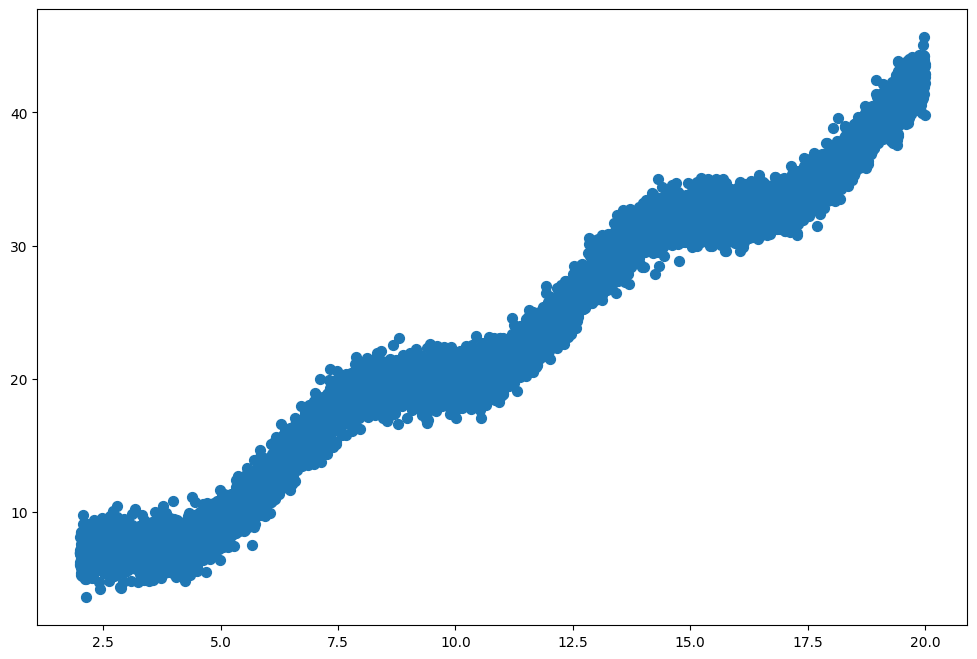

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(data['x'],data['y'],s=50)

In [6]:
data_train, data_test = train_test_split(data, test_size=0.2)

X_train = data_train['x'].values.reshape(-1,1)
y_train = data_train['y'].values.reshape(-1,1)

X_test = data_test['x'].values.reshape(-1,1)
y_test = data_test['y'].values.reshape(-1,1)

In [7]:
X_train_tensor = sorix.tensor(X_train).to(device)
y_train_tensor = sorix.tensor(y_train).to(device)

X_test_tensor = sorix.tensor(X_test).to(device)
y_test_tensor = sorix.tensor(y_test).to(device)

print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)

(8000, 1) (8000, 1) (2000, 1) (2000, 1)


In [8]:
model = Linear(1,1).to(device)

loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [9]:
for itr in range(1000+1):
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if itr % 100 == 0:
        print(f"Epoch: {itr:5d} | Loss: {loss.data:.6f}")

Epoch:     0 | Loss: 9.984354


Epoch:   100 | Loss: 2.999191
Epoch:   200 | Loss: 2.918521


Epoch:   300 | Loss: 2.870195


Epoch:   400 | Loss: 2.848459
Epoch:   500 | Loss: 2.840700


Epoch:   600 | Loss: 2.838458


Epoch:   700 | Loss: 2.837930
Epoch:   800 | Loss: 2.837828


Epoch:   900 | Loss: 2.837812


Epoch:  1000 | Loss: 2.837810


In [10]:
with sorix.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

print("Train")
print(regression_report(y_train_tensor, y_pred_train))
print("\nTest")
print(regression_report(y_test_tensor, y_pred_test))


Train
Metric |     Score |    Range
-----------------------------
R2     |    0.9744 | [0,   1]
MAE    |    1.4001 | [0,  ∞) 
MSE    |    2.8378 | [0,  ∞) 
RMSE   |    1.6846 | [0,  ∞) 
MAPE   |    8.3834 | [0, 100]

Test
Metric |     Score |    Range
-----------------------------
R2     |    0.9731 | [0,   1]
MAE    |    1.4353 | [0,  ∞) 
MSE    |    2.9983 | [0,  ∞) 
RMSE   |    1.7316 | [0,  ∞) 
MAPE   |    8.6767 | [0, 100]


In [11]:
model.coef_, model.intercept_

(array([1.99987638]), 0.9112314034416265)

Text(5, 5, 'y = 2.00x + 0.911')

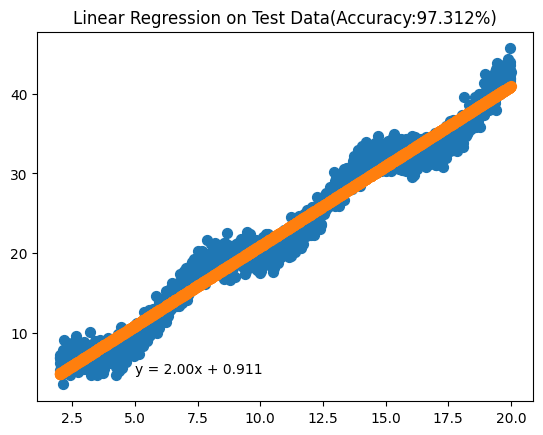

In [12]:
r2_test = r2_score(y_test_tensor, y_pred_test)

plt.scatter(X_test_tensor,y_test_tensor,s=50)
plt.scatter(X_test_tensor,y_pred_test,s=50)
plt.title(f'Linear Regression on Test Data(Accuracy:{r2_test*100:.3f}%)')
plt.text(5, 5, f'y = {model.coef_[0]:.2f}x + {model.intercept_:.3f}')

## Save Model

In [13]:
import joblib

In [14]:
joblib.dump(model.to('cpu'), 'regression_model.joblib')

['regression_model.joblib']

In [15]:
model2 = joblib.load('regression_model.joblib')
print(type(model2.coef_), type(model2.intercept_))
model2.to(device)
print(type(model2.coef_), type(model2.intercept_))

<class 'numpy.ndarray'> <class 'float'>
<class 'cupy.ndarray'> <class 'float'>


In [16]:
with sorix.no_grad():
    r2_train = r2_score(y_train_tensor, model2(X_train_tensor))
    r2_test =  r2_score(y_test_tensor, model2(X_test_tensor))
    print(f"R2 Train: {100*r2_train:5.2f} % | R2 Test: {100*r2_test:5.2f} %")

R2 Train: 97.44 % | R2 Test: 97.31 %
